In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

# Data loading

In [2]:
#PATHS
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [3]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents,desired_channels=1)
    
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate,rate_out=16000)
    
    return wav

In [5]:
#plot wave
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

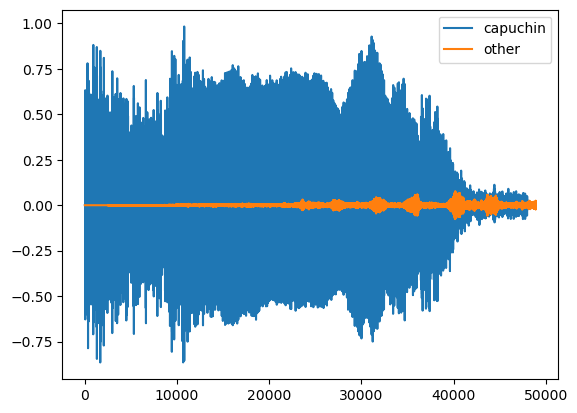

In [7]:
#visualise waves
plt.plot(wave, label="capuchin")
plt.plot(nwave, label="other")
plt.legend()
plt.show()

# tensorflow dataset

In [8]:
#define paths to positive and negative data
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [11]:
#create tensorflow dataset
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [ ]:
# Add labels and combine positive and negative samples
positives = tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))    
data = positives.concatenate(negatives)
#list(data.as_numpy_iterator())

# Average length of a Capuchin Call

In [30]:
lengths = []
for file in os.listdir(POS):
    tensor_wave = load_wav_16k_mono(os.path.join(POS,file))
    lengths.append(len(tensor_wave))

In [36]:
#calculate mean, min and max
print(tf.math.reduce_mean(lengths))
print(tf.math.reduce_min(lengths))
print(tf.math.reduce_max(lengths))

tf.Tensor(54156, shape=(), dtype=int32)
tf.Tensor(32000, shape=(), dtype=int32)
tf.Tensor(80000, shape=(), dtype=int32)


# Preprocessing function to convert to spectrogram

In [52]:
def preprocess(file_path):
    size = 48000
    wav = load_wav_16k_mono(filepath)
    wav = wav[:size] #we keep the 48000 firsts stape. Choose with the numbers above
    if len(wav)<size:
        zero_padding = tf.zeros([size]- tf.shape(wav), dtype=tf.float32) #Complete with 0 when no enough data as the less is at 32000
        wav = tf.concat([zero_padding,wav],0)
    spectrogram = tf.signal.stft(wav,frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

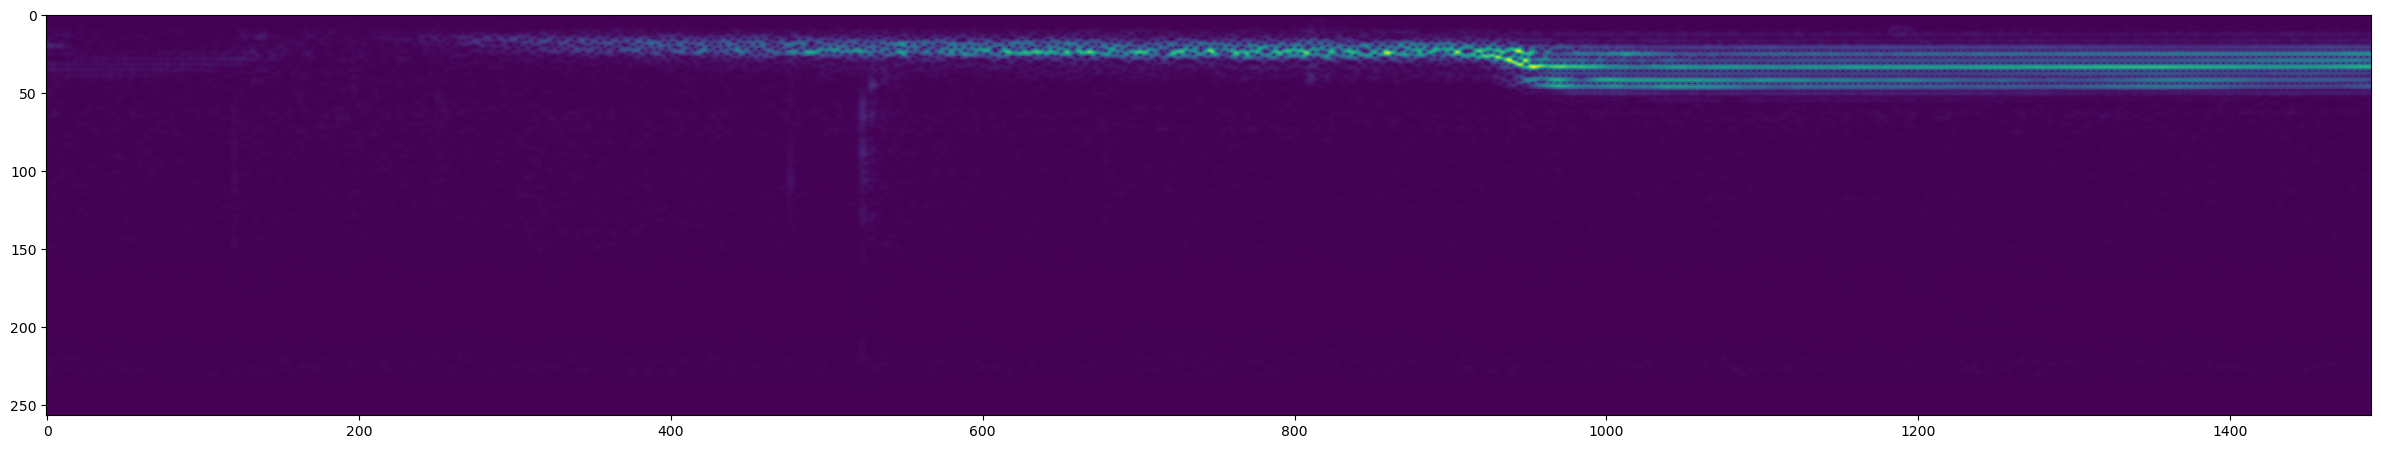

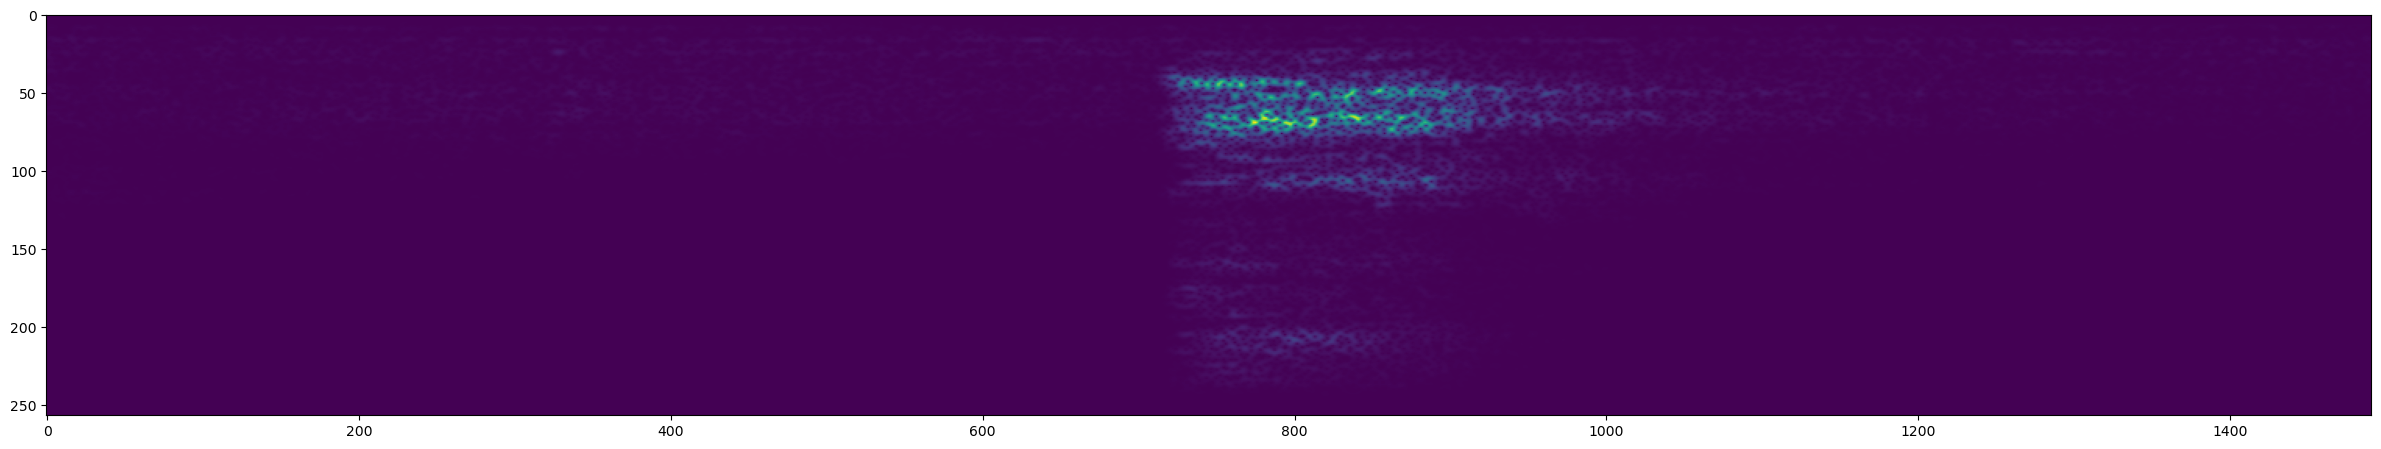

In [62]:
# test and vizualise the spectrogram
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram = preprocess(filepath)

plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram = preprocess(filepath)

plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Training and Testing Partitions